In [31]:
import numpy as np
import pandas as pd

from scipy.spatial.transform import Rotation as R

%matplotlib inline
import matplotlib.pyplot as plt

In [19]:
data_path = "data/2019_06_17_16_28_47"

tcm_raw = pd.read_csv( data_path+"tcm.csv", header=0, names=["Time", "roll", "pitch", "yaw"])
vnav_raw = pd.read_csv( data_path+"vnav.csv", header=0, names=["Time", "yaw","pitch","roll","magx","magy","magz","accelx","accely","accelz","gyrox","gyroy"])
yost_raw = pd.read_csv( data_path+"yost.csv")

all_raw = [tcm_raw, vnav_raw, yost_raw]

## Fixup missing time column in yostlabs for now
# yost_raw["Time"] = tcm_raw["Time"]

In [20]:
## Normalize all times and set time as index

t0 = min( [ f["Time"].min() for f in all_raw] )

for f in all_raw:
    f["Time"] = f["Time"]-t0
    f.set_index("Time", inplace=True)

## TODOS:

* Vectornav:
* Yost Labs:
* TCM:  Add magnetometer/compass data

* Convert to common reference frame (perhaps using quaternions)

In [21]:
## Quaternions to euler angles
def quat2euler( row ):
    r = R.from_quat([ row["quat 1"], row["quat 2"], row["quat 3"], row["quat 4"] ])
    e = r.as_euler('zyx')
    return pd.Series( {'yaw': e[0], 'pitch': e[1], 'roll': e[2]})

def euler2quat( row, order='xyz' ):
    r = R.from_euler( 'zyx', [row["roll"], row["pitch"], row["yaw"]])
    q = r.as_quat()
    return pd.Series( {'quat 1': q[0], 'quat 2': q[1], 'quat 3': q[2], 'quat 4': q[3]} )

In [22]:
# ## Convert to degrees?
# for col in ["roll", "pitch", "yaw"]:
#     tcm_raw[col] = tcm_raw[col] * 180/np.pi 

quat = tcm_raw.apply( euler2quat, axis=1 )

tcm = tcm_raw.merge( quat, left_index=True, right_index=True )
    
tcm.head(5)

,roll,pitch,yaw,quat 1,quat 2,quat 3,quat 4
Time,,,,,,,
0.000,0.016336,0.138145,-0.331835,-0.164202,0.069413,-0.003362,0.983976
0.080,0.016311,0.138097,-0.331863,-0.164217,0.069388,-0.003371,0.983975
0.166,0.016308,0.138061,-0.331899,-0.164235,0.069370,-0.003371,0.983973
0.247,0.016319,0.138025,-0.331977,-0.164274,0.069353,-0.003365,0.983968
0.331,0.016260,0.138027,-0.331912,-0.164243,0.069349,-0.003392,0.983973


In [25]:
## Convert to radians?
for col in ["roll", "pitch", "yaw"]:
    vnav_raw[col] = vnav_raw[col] * np.pi/180

quat = vnav_raw.apply( euler2quat, axis=1 )

vnav = vnav_raw.merge( quat, left_index=True, right_index=True )

vnav.head(5)

,yaw,pitch,roll,magx,magy,magz,accelx,accely,accelz,gyrox,gyroy,quat 1,quat 2,quat 3,quat 4
Time,,,,,,,,,,,,,,,
0.007,-1.959603,-0.085434,0.008098,-0.0215,0.1288,0.5131,-0.779,-0.086,-9.704,0.003110,-0.000836,-0.829719,-0.020435,0.037715,0.556531
0.091,-1.959586,-0.085416,0.008168,-0.0192,0.1300,0.5145,-0.807,-0.124,-9.722,0.002504,0.000511,-0.829715,-0.020401,0.037727,0.556537
0.175,-1.959551,-0.085469,0.008360,-0.0203,0.1337,0.5144,-0.793,-0.078,-9.696,0.000951,0.000708,-0.829706,-0.020337,0.037801,0.556547
0.255,-1.959499,-0.085399,0.008378,-0.0204,0.1300,0.5104,-0.817,-0.022,-9.788,0.001872,0.001399,-0.829693,-0.020311,0.037777,0.556569
0.339,-1.959446,-0.085347,0.008255,-0.0204,0.1300,0.5104,-0.843,-0.046,-9.738,0.001103,-0.000976,-0.829678,-0.020348,0.037720,0.556594


In [26]:


yost_raw.reset_index(inplace=True)
euler = yost_raw.apply( quat2euler, axis=1 )

yost = yost_raw.merge( euler, left_index=True, right_index=True )

yost.drop("unknown", axis=1, inplace=True)
yost.set_index("Time",inplace=True)
yost.head(5)

,index,quat 1,quat 2,quat 3,quat 4,yaw,pitch,roll
Time,,,,,,,,
0.000,0,0.918223,-0.012000,-0.395030,-0.026090,0.061945,-0.810772,-3.058190
0.080,1,-0.012086,-0.395946,-0.026075,0.917824,-0.083640,-0.812759,-0.062345
0.166,2,-0.012046,-0.396859,-0.026168,0.917427,-0.084022,-0.814742,-0.062532
0.247,3,0.917034,-0.012090,-0.397773,-0.026191,0.062863,-0.816721,-3.057280
0.331,4,0.916703,-0.012377,-0.398537,-0.026014,0.063588,-0.818368,-3.057269


<Figure size 432x288 with 0 Axes>

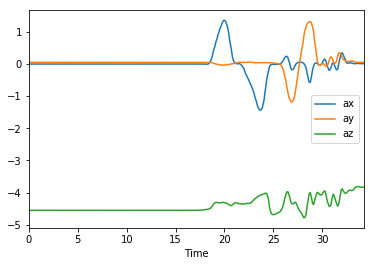

In [29]:
plt.figure()
tcm_raw.plot()

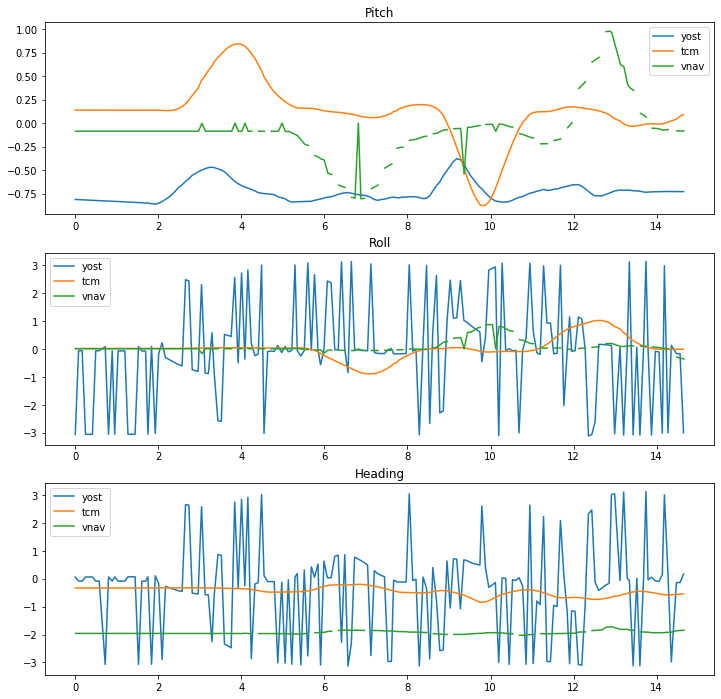

In [45]:
fig,ax = plt.subplots(3,1, figsize=(12,12))

ax[0].plot(yost['pitch'], label='yost')
ax[0].plot(tcm['pitch'], label='tcm')
ax[0].plot(vnav['pitch'], label='vnav')
ax[0].set_title('Pitch')
ax[0].legend()

ax[1].plot(yost['roll'], label='yost')
ax[1].plot(tcm['roll'], label='tcm')
ax[1].plot(vnav['roll'], label='vnav')
ax[1].set_title('Roll')
ax[1].legend()

ax[2].plot(yost['yaw'], label='yost')
ax[2].plot(tcm['yaw'], label='tcm')
ax[2].plot(vnav['yaw'], label='vnav')
ax[2].set_title('Heading')
ax[2].legend()